In [1]:
# Necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#  load datasets

import pandas as pd

# Update your file names exactly as they appear
nifty50_file = "NIFTY 50-01-04-2025-to-11-11-2025.csv"
niftybees_file = "Quote-Equity-NIFTYBEES-EQ-01-04-2025-to-12-11-2025.csv"

# Function to read and clean any file
def load_price_data(file_path, label):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()           # remove extra spaces
    df.rename(columns=lambda x: x.strip(), inplace=True)

    # Find date and close columns automatically
    date_col = [c for c in df.columns if "date" in c.lower()][0]
    close_col = [c for c in df.columns if "close" in c.lower()][0]

    df = df[[date_col, close_col]].copy()
    df.columns = ["Date", f"Close_{label}"]
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df = df.sort_values("Date").dropna()
    return df

# Load both datasets
nifty50 = load_price_data(nifty50_file, "NIFTY50")
niftybees = load_price_data(niftybees_file, "NIFTYBEES")

# Merge on Date
merged = pd.merge(nifty50, niftybees, on="Date", how="inner")

# Drop missing rows
merged = merged.dropna()

print("✅ Data loaded and merged successfully!")
print("Columns:", merged.columns.tolist())
print(merged.head())


✅ Data loaded and merged successfully!
Columns: ['Date', 'Close_NIFTY50', 'Close_NIFTYBEES']
        Date  Close_NIFTY50  Close_NIFTYBEES
0 2025-04-01       23165.70           263.21
1 2025-04-02       23332.35           259.60
2 2025-04-03       23250.10           261.64
3 2025-04-04       22904.45           260.46
4 2025-04-07       22161.60           257.16


C:\Users\Aditya\AppData\Local\Temp\ipykernel_19964\792447998.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors='coerce')


In [6]:
# ✅ CLEAN & PREPROCESS DATA (fixed version)

import pandas as pd

# --- Clean column names ---
nifty50.columns = nifty50.columns.str.strip()
niftybees.columns = niftybees.columns.str.strip()

# --- Find the correct column names dynamically ---
def get_close_column(df):
    # find any column that contains the word "close" (case insensitive)
    for col in df.columns:
        if "close" in col.lower():
            return col
    raise KeyError("No column containing 'close' found!")

close_col_nifty50 = get_close_column(nifty50)
close_col_niftybees = get_close_column(niftybees)

# --- Convert Date columns ---
date_col_nifty50 = [c for c in nifty50.columns if "date" in c.lower()][0]
date_col_niftybees = [c for c in niftybees.columns if "date" in c.lower()][0]

nifty50[date_col_nifty50] = pd.to_datetime(nifty50[date_col_nifty50], errors='coerce')
niftybees[date_col_niftybees] = pd.to_datetime(niftybees[date_col_niftybees], errors='coerce')

# --- Keep only Date and Close columns ---
nifty50 = nifty50[[date_col_nifty50, close_col_nifty50]]
niftybees = niftybees[[date_col_niftybees, close_col_niftybees]]

# --- Rename columns uniformly ---
nifty50.columns = ["Date", "Close_NIFTY50"]
niftybees.columns = ["Date", "Close_NIFTYBEES"]

# --- Sort and merge ---
nifty50 = nifty50.sort_values("Date")
niftybees = niftybees.sort_values("Date")

merged = pd.merge(nifty50, niftybees, on="Date", how="inner")

# --- Drop missing rows ---
merged = merged.dropna()

# ✅ Check the result
print("Columns found in NIFTY50:", nifty50.columns.tolist())
print("Columns found in NIFTYBEES:", niftybees.columns.tolist())
print("\n✅ Merged dataset (first 5 rows):\n", merged.head())


Columns found in NIFTY50: ['Date', 'Close_NIFTY50']
Columns found in NIFTYBEES: ['Date', 'Close_NIFTYBEES']

✅ Merged dataset (first 5 rows):
         Date  Close_NIFTY50  Close_NIFTYBEES
0 2025-04-01       23165.70           263.21
1 2025-04-02       23332.35           259.60
2 2025-04-03       23250.10           261.64
3 2025-04-04       22904.45           260.46
4 2025-04-07       22161.60           257.16


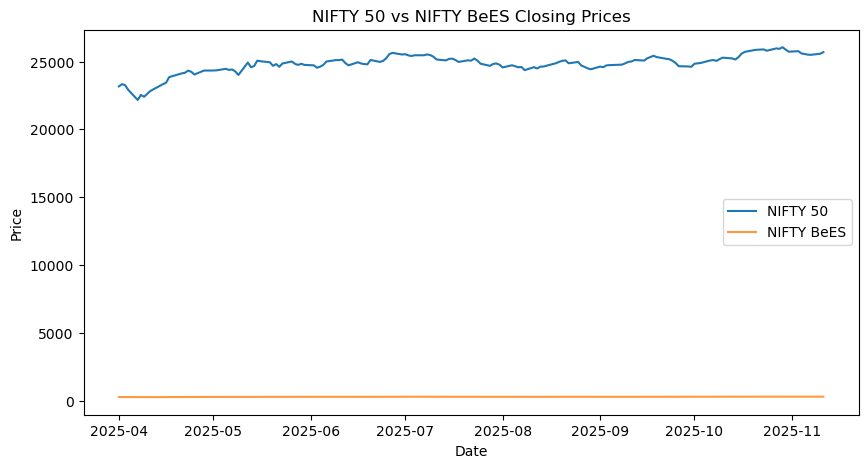

Correlation between NIFTY50 and NIFTYBEES: 0.9569


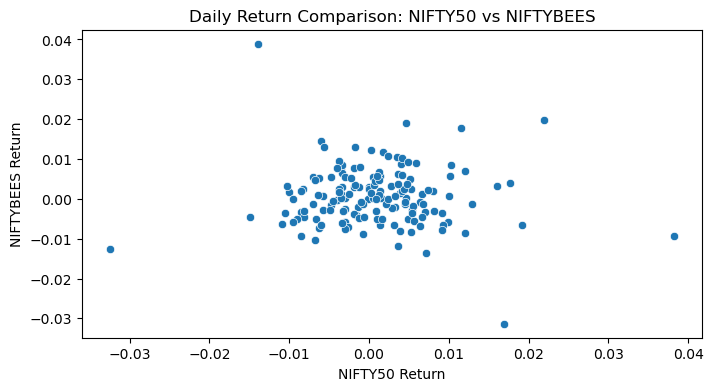

In [7]:
#  EDA - PLOTS AND STATS

plt.figure(figsize=(10,5))
plt.plot(merged["Date"], merged["Close_NIFTY50"], label="NIFTY 50")
plt.plot(merged["Date"], merged["Close_NIFTYBEES"], label="NIFTY BeES", alpha=0.8)
plt.legend()
plt.title("NIFTY 50 vs NIFTY BeES Closing Prices")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

# Correlation
corr = merged["Close_NIFTY50"].corr(merged["Close_NIFTYBEES"])
print(f"Correlation between NIFTY50 and NIFTYBEES: {corr:.4f}")

# Return comparison
merged["Return_NIFTY50"] = merged["Close_NIFTY50"].pct_change()
merged["Return_NIFTYBEES"] = merged["Close_NIFTYBEES"].pct_change()

plt.figure(figsize=(8,4))
sns.scatterplot(x=merged["Return_NIFTY50"], y=merged["Return_NIFTYBEES"])
plt.title("Daily Return Comparison: NIFTY50 vs NIFTYBEES")
plt.xlabel("NIFTY50 Return"); plt.ylabel("NIFTYBEES Return")
plt.show()


In [8]:
#  FEATURE ENGINEERING

df = merged.copy()
df["Log_NIFTY50"] = np.log(df["Close_NIFTY50"])
df["Log_NIFTYBEES"] = np.log(df["Close_NIFTYBEES"])

df["Return_NIFTY50"] = df["Close_NIFTY50"].pct_change()
df["Return_NIFTYBEES"] = df["Close_NIFTYBEES"].pct_change()

df["SMA_7_NIFTY50"] = df["Close_NIFTY50"].rolling(7).mean()
df["SMA_21_NIFTY50"] = df["Close_NIFTY50"].rolling(21).mean()

df["SMA_7_NIFTYBEES"] = df["Close_NIFTYBEES"].rolling(7).mean()
df["SMA_21_NIFTYBEES"] = df["Close_NIFTYBEES"].rolling(21).mean()

df = df.dropna()
print(df.head())


         Date  Close_NIFTY50  Close_NIFTYBEES  Return_NIFTY50  \
20 2025-05-05       24461.15           272.05        0.004701   
21 2025-05-06       24379.60           274.39       -0.003334   
22 2025-05-07       24414.40           272.60        0.001427   
23 2025-05-08       24273.80           272.79       -0.005759   
24 2025-05-09       24008.00           271.04       -0.010950   

    Return_NIFTYBEES  Log_NIFTY50  Log_NIFTYBEES  SMA_7_NIFTY50  \
20          0.000221    10.104841       5.605986   24298.935714   
21          0.008601    10.101502       5.614550   24317.921429   
22         -0.006524    10.102928       5.608006   24371.500000   
23          0.000697    10.097153       5.608702   24363.685714   
24         -0.006415    10.086142       5.602266   24316.835714   

    SMA_21_NIFTY50  SMA_7_NIFTYBEES  SMA_21_NIFTYBEES  
20    23614.735714       271.321429        263.771905  
21    23672.540476       271.688571        264.304286  
22    23724.066667       271.924286   

In [9]:
#  STATIONARITY TEST (ADF)

from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("  => Stationary\n")
    else:
        print("  => Non-stationary\n")

adf_test(df["Log_NIFTY50"], "Log NIFTY50")
adf_test(df["Log_NIFTYBEES"], "Log NIFTYBEES")


ADF Test for Log NIFTY50:
  Statistic: -2.3094
  p-value: 0.1690
  => Non-stationary

ADF Test for Log NIFTYBEES:
  Statistic: -2.2849
  p-value: 0.1769
  => Non-stationary



In [10]:
#  SPLIT DATA INTO TRAIN AND TEST

split_ratio = 0.8
split = int(len(df) * split_ratio)

train = df.iloc[:split]
test = df.iloc[split:]

print("Train shape:", train.shape, "Test shape:", test.shape)


Train shape: (105, 11) Test shape: (27, 11)


c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a

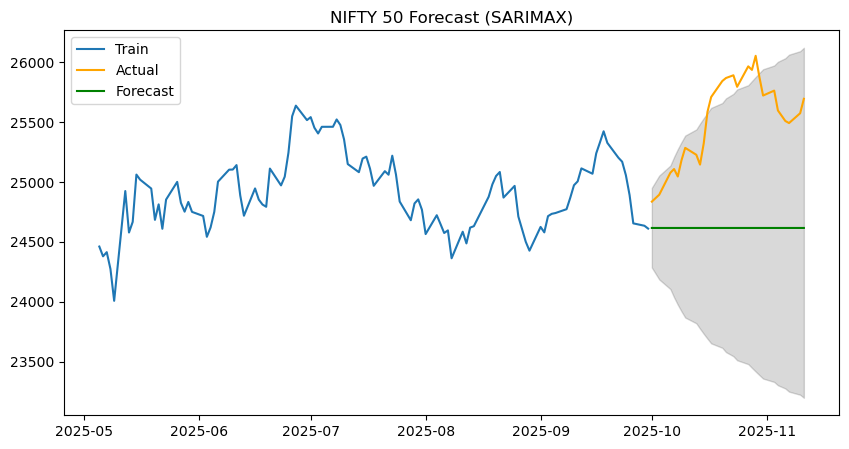

NIFTY50 -> MAE: 902.46, RMSE: 967.58


In [12]:
# FORECAST NIFTY50

import math


model_nifty50 = SARIMAX(train["Log_NIFTY50"], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
result_nifty50 = model_nifty50.fit(disp=False)

forecast_nifty50 = result_nifty50.get_forecast(steps=len(test))
pred_mean_log = forecast_nifty50.predicted_mean
pred_ci = forecast_nifty50.conf_int()

# Convert log back to actual price
predicted_price = np.exp(pred_mean_log)
lower_ci = np.exp(pred_ci.iloc[:, 0])
upper_ci = np.exp(pred_ci.iloc[:, 1])

# Plot
plt.figure(figsize=(10,5))
plt.plot(train["Date"], train["Close_NIFTY50"], label="Train")
plt.plot(test["Date"], test["Close_NIFTY50"], label="Actual", color="orange")
plt.plot(test["Date"], predicted_price, label="Forecast", color="green")
plt.fill_between(test["Date"], lower_ci, upper_ci, color='k', alpha=0.15)
plt.title("NIFTY 50 Forecast (SARIMAX)")
plt.legend()
plt.show()

# Evaluation
mae = mean_absolute_error(test["Close_NIFTY50"], predicted_price)
rmse = math.sqrt(mean_squared_error(test["Close_NIFTY50"], predicted_price))
print(f"NIFTY50 -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")


c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a

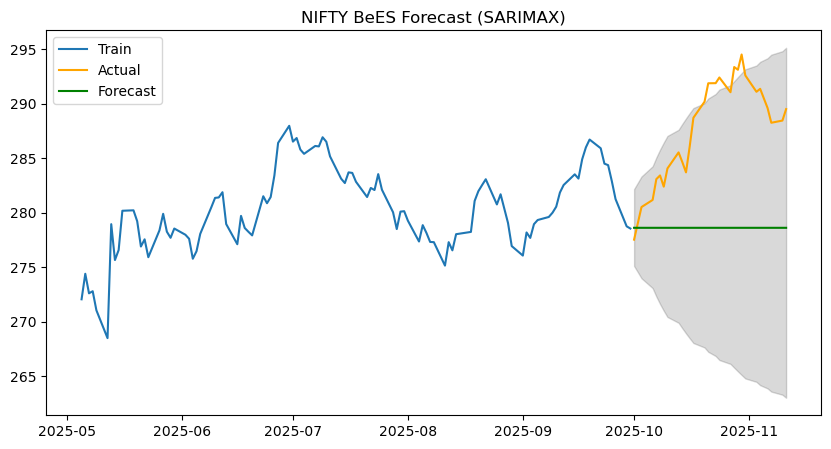

NIFTYBEES -> MAE: 9.24, RMSE: 10.22


In [13]:
#  FORECAST NIFTYBEES

model_bees = SARIMAX(train["Log_NIFTYBEES"], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
result_bees = model_bees.fit(disp=False)

forecast_bees = result_bees.get_forecast(steps=len(test))
pred_mean_log_bees = forecast_bees.predicted_mean
pred_ci_bees = forecast_bees.conf_int()

predicted_price_bees = np.exp(pred_mean_log_bees)
lower_ci_bees = np.exp(pred_ci_bees.iloc[:, 0])
upper_ci_bees = np.exp(pred_ci_bees.iloc[:, 1])

plt.figure(figsize=(10,5))
plt.plot(train["Date"], train["Close_NIFTYBEES"], label="Train")
plt.plot(test["Date"], test["Close_NIFTYBEES"], label="Actual", color="orange")
plt.plot(test["Date"], predicted_price_bees, label="Forecast", color="green")
plt.fill_between(test["Date"], lower_ci_bees, upper_ci_bees, color='k', alpha=0.15)
plt.title("NIFTY BeES Forecast (SARIMAX)")
plt.legend()
plt.show()

mae_bees = mean_absolute_error(test["Close_NIFTYBEES"], predicted_price_bees)
rmse_bees = math.sqrt(mean_squared_error(test["Close_NIFTYBEES"], predicted_price_bees))
print(f"NIFTYBEES -> MAE: {mae_bees:.2f}, RMSE: {rmse_bees:.2f}")


In [15]:
#Correlation & Cointegration

from statsmodels.tsa.stattools import coint

corr = merged["Close_NIFTY50"].corr(merged["Close_NIFTYBEES"])
coint_t, p_value, _ = coint(merged["Close_NIFTY50"], merged["Close_NIFTYBEES"])

print(f"Correlation: {corr:.4f}")
print(f"Cointegration Test p-value: {p_value:.4f}")


Correlation: 0.9569
Cointegration Test p-value: 0.2211


Mean Tracking Error %: -98.8755587436461


<Axes: title={'center': 'Tracking Error (%) Over Time'}>

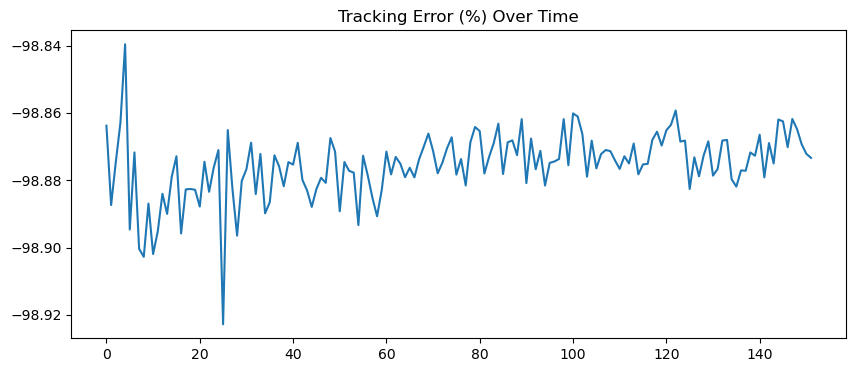

In [16]:
# Shows how closely NIFTYBEES mirrors NIFTY50
merged["Tracking_Error"] = merged["Close_NIFTYBEES"] - merged["Close_NIFTY50"]
merged["Tracking_Error_%"] = (merged["Tracking_Error"] / merged["Close_NIFTY50"]) * 100

print("Mean Tracking Error %:", merged["Tracking_Error_%"].mean())
merged["Tracking_Error_%"].plot(title="Tracking Error (%) Over Time", figsize=(10,4))


In [14]:
#  FUTURE PREDICTION (NEXT 30 DAYS)

model_full_nifty = SARIMAX(df["Log_NIFTY50"], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
model_full_bees = SARIMAX(df["Log_NIFTYBEES"], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Predict next 30 business days
future_steps = 30
future_index = pd.date_range(start=df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')

future_nifty = model_full_nifty.get_forecast(steps=future_steps)
future_bees = model_full_bees.get_forecast(steps=future_steps)

future_nifty_price = np.exp(future_nifty.predicted_mean)
future_bees_price = np.exp(future_bees.predicted_mean)

future_df = pd.DataFrame({
    "Date": future_index,
    "NIFTY50_Predicted": future_nifty_price.values,
    "NIFTYBEES_Predicted": future_bees_price.values
})

print("\nFuture 30-Day Predictions:\n")
print(future_df.head(10))
future_df.to_csv("Future_30Days_Predictions.csv", index=False)
print("\n✅ Future forecast saved as 'Future_30Days_Predictions.csv'")



Future 30-Day Predictions:

        Date  NIFTY50_Predicted  NIFTYBEES_Predicted
0 2025-11-12       25680.743007           289.395289
1 2025-11-13       25681.909686           289.407010
2 2025-11-14       25681.813852           289.405559
3 2025-11-17       25681.821724           289.405738
4 2025-11-18       25681.821077           289.405716
5 2025-11-19       25681.821131           289.405719
6 2025-11-20       25681.821126           289.405719
7 2025-11-21       25681.821127           289.405719
8 2025-11-24       25681.821127           289.405719
9 2025-11-25       25681.821127           289.405719

✅ Future forecast saved as 'Future_30Days_Predictions.csv'


c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 